[![Open in Colab](https://colab.reserach.google.com/assets/colab-badge.svg)](https://github.com/ellacharmed/machine-learning-zoomcamp/blob/week08/cohorts/2023/08-deep-learning/homework-08.ipynb)

# Homework for week08

> In this homework, we'll build a model for predicting if we have an image of a bee or a wasp. 
For this, we will use the "Bee or Wasp?" dataset that was obtained from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp) and slightly rebuilt. 


### Dataset

> You can download the dataset for this homework from [here](https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip):

```bash
wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
unzip data.zip
```


In [1]:
# !wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
# !unzip data.zip

In [2]:
import timeit
start_time = timeit.default_timer()
print("The notebook starting time  is :", start_time)

The notebook starting time  is : 11738.674591603


In [3]:
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

## Import Packages

In [4]:
import matplotlib_inline
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import sklearn as sk
import sys
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Numpy {np.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print()
print()
print("Python version:", sys.version)
print("Python executable:", sys.executable)

Tensor Flow Version: 2.14.0
Numpy 1.24.4
Pandas 2.1.2
Scikit-Learn 1.3.1


Python version: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
Python executable: /home/ellanix/micromamba/envs/zoomcamp/bin/python


In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Avoid OOM errors by setting GPU Memory Consumption Growth
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print(f"GPU set_memory_growth SUCCESS")
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

Num GPUs Available:  1
GPU set_memory_growth SUCCESS


In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

<tf.Tensor: shape=(), dtype=float32, numpy=-337.05658>

In [8]:
from tensorflow import keras

from tensorflow.python.client import device_lib



In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch. 

> **Note:** you will need an environment with a GPU for this homework. We recommend to use [Saturn Cloud](https://bit.ly/saturn-mlzoomcamp). 
> You can also use a computer without a GPU (e.g. your laptop), but it will be slower.


### Data Preparation

The dataset contains around 2500 images of bees and around 2100 images of wasps. 

The dataset contains separate folders for training and test sets. 


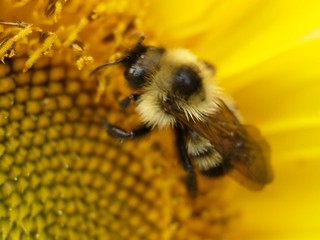

In [9]:
from tensorflow.keras.preprocessing.image import load_img
path = './data/train/bee'
name = '30593623_7199aec756_n.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

### Question 1 :  `binary crossentropy`

Since we have a binary classification problem, what is the best loss function for us?

* `mean squared error`
* `binary crossentropy`
* `categorical crossentropy`
* `cosine similarity`

> **Note:** since we specify an activation for the output layer, we don't need to set `from_logits=True`


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Generators and Training

For the next two questions, use the following data generator for both train and test sets:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/test directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and test sets. 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)
```

> The shape for input should be `(150, 150, 3)`

In [11]:
target_size=(150, 150)
batch_size=20
shuffle=True

In [12]:
train_gen = ImageDataGenerator(rescale=1./255)
train_ds = train_gen.flow_from_directory(
    './data/train',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle,
    class_mode='binary'
)

Found 3677 images belonging to 2 classes.


In [13]:
train_ds.class_indices

{'bee': 0, 'wasp': 1}

In [14]:
test_gen = ImageDataGenerator(rescale=1./255)
test_ds = test_gen.flow_from_directory(
    './data/test',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle,
    class_mode='binary'
)

Found 918 images belonging to 2 classes.



### Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

For clarification about kernel size and max pooling, check [Office Hours](https://www.youtube.com/watch?v=1WRgdBTUaAc).

In [15]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [16]:
input_shape=(150, 150, 3)

In [17]:
model = Sequential()

model.add(Conv2D(
    filters=32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
# Functional API version

# inputs = keras.Input(shape=input_shape)
# conv = keras.layers.Conv2D(
#     filters=32, 
#     kernel_size=(3, 3), 
#     activation='relu', 
#     input_shape=input_shape)(inputs)
# pooling = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
# vectors = keras.layers.Flatten()(pooling)
# features = keras.layers.Dense(64, activation='relu')(vectors)
# outputs = keras.layers.Dense(1, activation='sigmoid')(features)

# model = keras.Model(inputs, outputs)

# Qn4 ans 0.094 for Sequential; 0.082 for Functional API. 
# Sticking to Sequential code. 
# Difference something to do with seed?

In [19]:
learning_rate = 0.002
momentum = 0.8

optimizer = keras.optimizers.SGD(
    learning_rate=learning_rate, 
    momentum=momentum)  

loss = keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])



### Question 2 : `896`

What's the number of parameters in the convolutional layer of our model? You can use the `summary` method for that. 

* 1 
* 65
* 896
* 11214912


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11215873 (42.79 MB)
Trainable params: 11215873 (42.79 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [21]:
logdir='logs'

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
history = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=test_ds
    # callbacks=[tensorboard_callback]
)

Epoch 1/10
184/184 [==============================] - 121s 648ms/step - loss: 0.6931 - accuracy: 0.5393 - val_loss: 0.6854 - val_accuracy: 0.5969
Epoch 2/10
184/184 [==============================] - 23s 123ms/step - loss: 0.6783 - accuracy: 0.5708 - val_loss: 0.6531 - val_accuracy: 0.6057
Epoch 3/10
184/184 [==============================] - 22s 121ms/step - loss: 0.6505 - accuracy: 0.6201 - val_loss: 0.6361 - val_accuracy: 0.5664
Epoch 4/10
184/184 [==============================] - 23s 123ms/step - loss: 0.6157 - accuracy: 0.6549 - val_loss: 0.5726 - val_accuracy: 0.7037
Epoch 5/10
184/184 [==============================] - 23s 125ms/step - loss: 0.5728 - accuracy: 0.7003 - val_loss: 0.6378 - val_accuracy: 0.6525
Epoch 6/10
184/184 [==============================] - 23s 124ms/step - loss: 0.5361 - accuracy: 0.7362 - val_loss: 0.5432 - val_accuracy: 0.7222
Epoch 7/10
184/184 [==============================] - 23s 125ms/step - loss: 0.5092 - accuracy: 0.7667 - val_loss: 0.5322 - val_a


### Question 3 : `0.80`

What is the median of training accuracy for all the epochs for this model?

* 0.20
* 0.40
* 0.60
* 0.80

In [24]:
np.median(history.history['accuracy']).round(2)

0.72

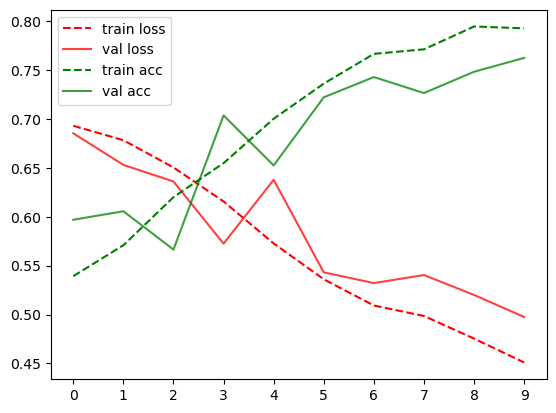

In [26]:
plt.plot(history.history['loss'], 'r--', label='train loss')
plt.plot(history.history['val_loss'], label='val loss', color='red', alpha=0.75)
plt.plot(history.history['accuracy'], 'g--', label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc', color='green', alpha=0.75)
plt.xticks(np.arange(10))
plt.legend()
plt.show()

### Question 4: `0.94` (0.094 for Sequential; 0.082 for Functional API)

What is the standard deviation of training loss for all the epochs for this model?

* 0.31
* 0.61
* 0.91
* 1.31

*Answer is still option 3 regardless of which code used.*

In [27]:
loss = history.history['loss']
print(f'mean: {np.mean(loss).round(3)}')
print(f' std +- {np.std(loss).round(3)}')

mean: 0.568
 std +- 0.083



### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=50,`
* `width_shift_range=0.1,`
* `height_shift_range=0.1,`
* `zoom_range=0.1,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`



In [28]:
# apply augmentations only on training data
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = train_gen.flow_from_directory(
    './data/train',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle,
    class_mode='binary'
)

test_gen = ImageDataGenerator(
    rescale=1./255,
)
test_ds = test_gen.flow_from_directory(
    './data/test',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle,
    class_mode='binary'
)

Found 3677 images belonging to 2 classes.
Found 918 images belonging to 2 classes.


In [29]:
history_aug = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=test_ds
    # callbacks=[tensorboard_callback]
)

Epoch 1/10
184/184 [==============================] - 36s 197ms/step - loss: 0.5072 - accuracy: 0.7639 - val_loss: 0.4939 - val_accuracy: 0.7778
Epoch 2/10
184/184 [==============================] - 36s 196ms/step - loss: 0.4960 - accuracy: 0.7648 - val_loss: 0.4983 - val_accuracy: 0.7571
Epoch 3/10
184/184 [==============================] - 37s 199ms/step - loss: 0.4905 - accuracy: 0.7737 - val_loss: 0.4732 - val_accuracy: 0.7843
Epoch 4/10
184/184 [==============================] - 36s 197ms/step - loss: 0.4911 - accuracy: 0.7650 - val_loss: 0.4655 - val_accuracy: 0.7789
Epoch 5/10
184/184 [==============================] - 36s 197ms/step - loss: 0.4827 - accuracy: 0.7724 - val_loss: 0.4585 - val_accuracy: 0.7985
Epoch 6/10
184/184 [==============================] - 36s 195ms/step - loss: 0.4837 - accuracy: 0.7775 - val_loss: 0.4693 - val_accuracy: 0.7898
Epoch 7/10
184/184 [==============================] - 36s 197ms/step - loss: 0.4723 - accuracy: 0.7841 - val_loss: 0.4781 - val_ac

### Question 5 : `0.48`

Let's train our model for 10 more epochs using the same code as previously.
> **Note:** make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

* 0.18
* 0.48
* 0.78
* 0.108

In [30]:
np.mean(history_aug.history['val_loss']).round(3)

0.469

In [31]:
loss = history_aug.history['loss']
print(f'mean: {np.mean(loss).round(3)}')
print(f' std +- {np.std(loss).round(3)}')

mean: 0.483
 std +- 0.012


#### Comparison of val_accuracy after augmentations

In [39]:
acc = history.history['val_accuracy']
acc_aug = history_aug.history['val_accuracy']

print('--------- BEFORE ---------')
print(f'mean: {np.mean(acc).round(3)}  std +- {np.std(acc).round(3)}')
print()
print('--------- AFTER  ---------')
print(f'mean: {np.mean(acc_aug).round(3)}  std +- {np.std(acc_aug).round(3)}')

--------- BEFORE ---------
mean: 0.683  std +- 0.068

--------- AFTER  ---------
mean: 0.788  std +- 0.015


### Question 6 : `0.78`

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

* 0.38
* 0.58
* 0.78
* 0.98



In [33]:
np.mean(history_aug.history['val_accuracy'][5:10]).round(3)

0.796

In [34]:
# Run the op several times.
print('Time (s) to run notebook in local vs-code with GTX 970')

cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(f'CPU (s): {cpu_time}')
print()

gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(f'GPU (s): {gpu_time}')
print()
print(f'GPU speedup over CPU: {int(cpu_time/gpu_time)}x')

Time (s) to run notebook in local vs-code with GTX 970
CPU (s): 0.7871611989994562

GPU (s): 0.19336069900055008

GPU speedup over CPU: 4x


In [35]:
import datetime

def hours_minutes(td):
    hours = td.seconds//3600
    minutes  = (td.seconds//60)%60
    seconds = td.seconds - minutes*60
    return hours, minutes, seconds

def minutes_second(td):
    minutes  = (td.seconds//60)%60
    seconds = td.seconds - minutes*60
    return minutes, seconds


In [36]:
elapsed = timeit.default_timer() - start_time
mins, sec = minutes_second(datetime.timedelta(seconds=elapsed))

print(f"The notebook completion time  is : {mins} minutes and {sec} seconds")

The notebook completion time  is : 11 minutes and 48 seconds


## References

This notebook runs smoothly due to code snippets I used from these notebooks and posts. My thanks to the authors for the guides/answers.

- [tensorflow and libraries versions, tensorflow install](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/manual_setup.ipynb)
- https://www.tensorflow.org/guide/gpu
- [OOM errors](https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth)
- [cpu() and gpu() code](https://colab.research.google.com/notebooks/gpu.ipynb)
- [elapsed to timedelta](https://stackoverflow.com/a/51846797)
- [timedelta components](https://stackoverflow.com/a/2119512)